Analysis of Plasmodium rebalancing in run10_11_v3. Based on experience from same samples in run10_11, the following conditions were used:

- two panel variants 80x P1/10x P2 `8010`; 80x P1/5x P2 `805`
- two annealing/extension temperatures for PCR1: 51C (decreased) & 55C (standard)
- two feed experiments with infection rate estimated as 60% (f15) and 94% (f16)
- two to three sampling points during high (day 1, blood stage parasites still present) and low (days 8-14, oocysts/sporozoites only left) expected infection intensities - 16 mosquito individuals per sampling point
- two rounds of DNA extraction from the same individuals: e1 - non-destructive, e2 - grinding with beads

Results:
- at 51C, P1 amplification is much more efficient, but average mosquito amplification is moderately supressed. Interestingly, individual amplicon efficiencies changed unevenly, e.g. amplicon 53 had low read counts only at 51C, while amplicon 55 had low read counts only at 55C.
- extraction did not have significant effect on read yields
- P2/P1 balance for 80x P1/10x P2 at 55C: 10.9x, r=0.95. At 51C: 0.71x, r=0.99
- P2/P1 balance for 80x P1/5x P2 at 55C: 2.5x, r=0.95. At 51C: 0.17x, r=0.99
- Compared to v2 run, P2/P1 ratio decreased two-fold, while the 4x difference between panel variants was retained.
- Infection identification was efficient for all conditions. 
- Read counts were mostly consistent between replicates - for both Plasmodium and mosquito amplicons

Conclusion: given the evidence from amplicon sequencing combined with qPCR results the following conditions look optimal: primer balance 80x P1/10x P2, non-destructive extraction, 55C annealing/extension, standard number of cycles. Using this concentration of P2 allows for more sensitive detection of low-density infections without compromising the resulting prediction accuracy (i.e. without increase in false-positive rate - based on qPCR as ground truth).



In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [2]:
READS = '../../../data/phylo_ampl_dada2/run10_11_v3/dada2/output/stats.tsv'
HAPS = '../../../data/phylo_ampl_dada2/run10_11_v3/dada2/output/haplotypes.tsv'

## Data prep

In [3]:
reads = pd.read_csv(READS, sep='\t')
reads.sample()

,s_Sample,target,input,filtered,denoisedF,denoisedR,merged,nonchim,final
31755,805_51_e2_f15_un3,19,154,151,151,151,151,151,151


In [4]:
# mean read counts across mosquito targets
mean_mosq = reads[~reads.target.str.startswith('P')].groupby('s_Sample').mean().reset_index()
mean_mosq['target'] = 'M_avg'
mean_mosq.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
153,8010_51_e2_f16_1d16,12.887097,12.564516,12.451613,12.354839,12.209677,12.209677,9.032258,M_avg


In [5]:
# total read counts across mosquito targets
sum_mosq = reads[~reads.target.str.startswith('P')].groupby('s_Sample').sum().reset_index()
sum_mosq['target'] = 'M_sum'
sum_mosq.sample()

,s_Sample,input,filtered,denoisedF,denoisedR,merged,nonchim,final,target
364,805_51_e1_f15_13d8,13295,13126,13125,13126,13118,13118,13110,M_sum


In [6]:
# subset to plasmodium targets only
display(reads.shape)
reads = reads[reads.target.str.startswith('P')]
display(reads.shape)

(45568, 9)

(1424, 9)

In [7]:
# add averaged mosquito targets
display(reads.shape)
reads = pd.concat([reads, mean_mosq, sum_mosq], sort=True)
display(reads.shape)

(1424, 9)

(2848, 9)

In [8]:
# logscale input and output reads for plotting
reads['log_input'] = np.log10(reads['input'].replace(0,0.1))
reads['log_final'] = np.log10(reads['final'].replace(0,0.1))

In [9]:
reads[reads.s_Sample.str.contains('un')]

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,log_input,log_final
3198,4.0,4.0,4.0,0.0,4.0,4.0,4.0,8010_51_e1_f15_un1,P1,0.602060,-1.000000
3199,2.0,2.0,2.0,0.0,2.0,2.0,2.0,8010_51_e1_f15_un1,P2,0.301030,-1.000000
3262,6.0,6.0,6.0,0.0,6.0,6.0,6.0,8010_51_e1_f15_un2,P1,0.778151,-1.000000
3263,2.0,2.0,2.0,0.0,2.0,2.0,2.0,8010_51_e1_f15_un2,P2,0.301030,-1.000000
3326,4.0,4.0,4.0,0.0,4.0,4.0,4.0,8010_51_e1_f15_un3,P1,0.602060,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...
675,25516.0,25482.0,25524.0,25380.0,25983.0,25394.0,25394.0,805_55_e2_f15_un4,M_sum,4.414689,4.404492
676,16418.0,16419.0,16421.0,16354.0,16723.0,16412.0,16412.0,805_55_e2_f15_un5,M_sum,4.223314,4.213624
677,15412.0,15408.0,15422.0,15317.0,15732.0,15320.0,15320.0,805_55_e2_f15_un6,M_sum,4.196784,4.185174
678,1581.0,1582.0,1582.0,1489.0,1673.0,1567.0,1567.0,805_55_e2_f15_un7,M_sum,3.223496,3.172895


In [10]:
# parse sequence names
def parse_sequence_names(reads):
    p = reads.s_Sample.str.split('_', expand=True)
    reads['panel'] = p[0]
    reads['temp'] = p[1] + 'C'
    reads['extraction'] = p[2]
    reads['feed'] = p[3]
    # parse day and indivudual
    di = p[4].str.split('d', expand=True)
    reads['day'] = di[0]
    reads['indivudual'] = di[1]
    # handle uninfected
    u = reads['s_Sample'].str.contains('un')
    reads.loc[u, 'indivudual'] = reads.loc[u, 'day'].str.slice(start=2)
    reads.loc[u, 'day'] = 'un'
    # handle day sorting
    sdd = reads.day.str.len() == 1
    reads.loc[sdd, 'day'] = '0' + reads.loc[sdd, 'day']
    # sampling points - combination of feed and day
    reads['sampling_point'] = reads.feed + '_' + reads.day
    reads['sampling_point'] = reads['sampling_point'].replace({'f15_13':'f15_13-14','f15_14':'f15_13-14'})
    
    return reads
reads = parse_sequence_names(reads)
reads.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,log_input,log_final,panel,temp,extraction,feed,day,indivudual,sampling_point
479,177.16129,177.241935,177.241935,176.080645,179.790323,176.274194,176.274194,805_51_e2_f15_8d10,M_avg,2.254766,2.245712,805,51C,e2,f15,08,10,f15_08


## Blanks

In [11]:
# read counts in blanks - only for mosquito-plasmodium mixes
reads['blank'] = 'no'
reads.loc[reads.s_Sample.str.contains('blank'), 'blank'] = 'yes'

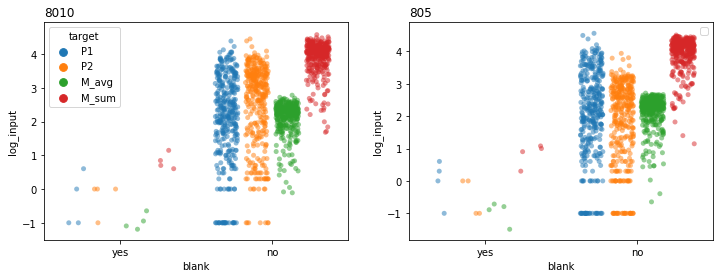

In [12]:
fig, axs = plt.subplots(1,2, figsize=(12, 4))
for panel, ax in zip(['8010', '805'],
                     axs.flatten()):
    sns.stripplot(data=reads[reads.s_Sample.str.startswith(panel)],
                   x='blank', 
                   y='log_input',
                   hue='target',
                   dodge=True,
                   jitter=.3,
                   alpha=.5,
                   ax=ax);
    ax.set_title(panel, loc='left')
    # legend only in first subplot
    if panel!='8010':
        ax.legend([])

In [13]:
# discard blanks
reads = reads[reads['blank'] == 'no']
reads.shape

(2816, 19)

## Panel and temperature overview

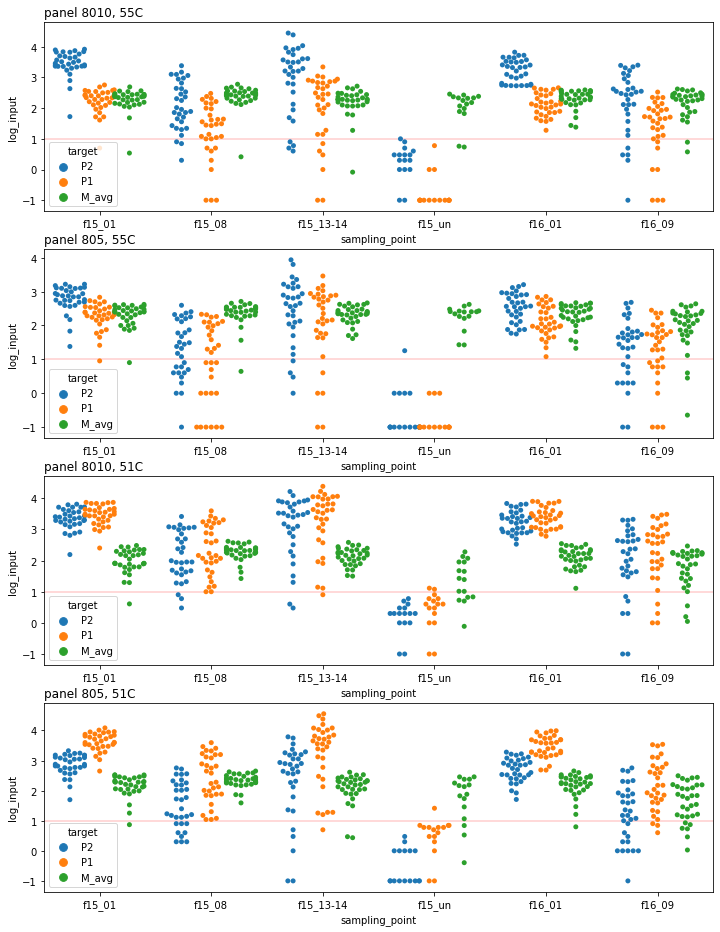

In [14]:
# overall picture for primer balances and temperatures
# disregarding extractions
fig, axs = plt.subplots(4,1, figsize=(12, 16))
for i, (temp, panel) in enumerate(itertools.product(('55C','51C'), ('8010','805'))):
    d = reads[(reads.panel == panel) & 
              (reads.temp == temp) & 
              (reads.target != 'M_sum')] \
            .sort_values('sampling_point')
    sns.swarmplot(data=d, 
                   x="sampling_point", 
                   y="log_input", 
                   hue="target", 
                   dodge=True,
                   ax=axs[i])
    axs[i].axhline(1,c='r', alpha=.2)
    axs[i].set_title("panel {}, {}".format(panel, temp), loc='left')

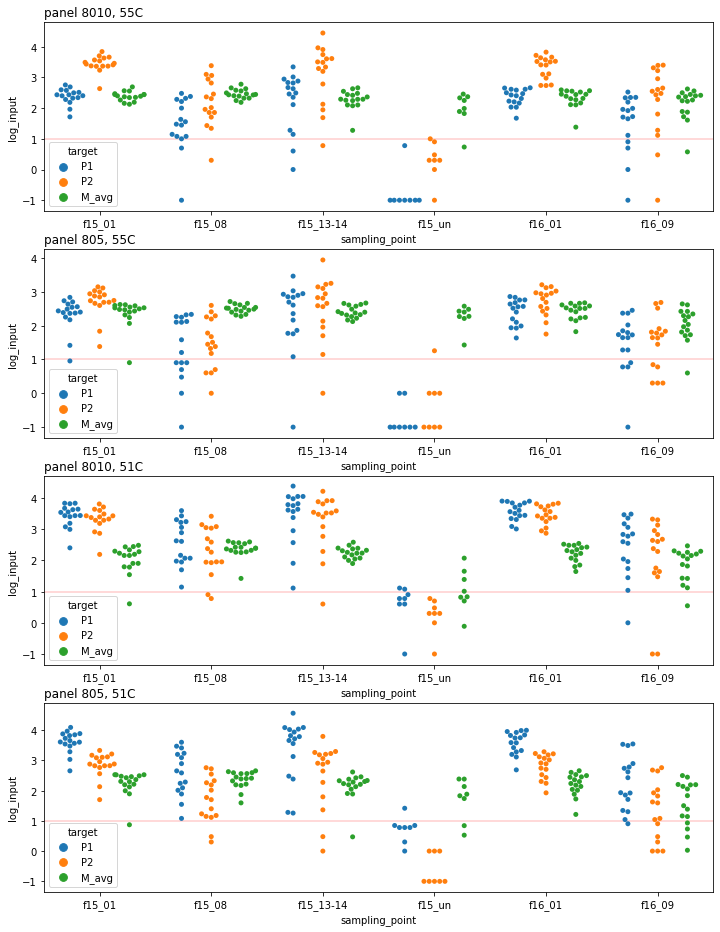

In [15]:
# overall picture for primer balances and temperatures
#  only for fisrt extraction - the one that will be used
fig, axs = plt.subplots(4,1, figsize=(12, 16))
for i, (temp, panel) in enumerate(itertools.product(('55C','51C'), ('8010','805'))):
    d = reads[(reads.panel == panel) & 
              (reads.temp == temp) & 
              (reads.target != 'M_sum') &
              (reads.extraction == 'e1')] \
            .sort_values('sampling_point')
    sns.swarmplot(data=d, 
                   x="sampling_point", 
                   y="log_input", 
                   hue="target", 
                   dodge=True,
                   ax=axs[i])
    axs[i].axhline(1,c='r', alpha=.2)
    axs[i].set_title("panel {}, {}".format(panel, temp), loc='left')

## Effects of individual variables - comparing replicates

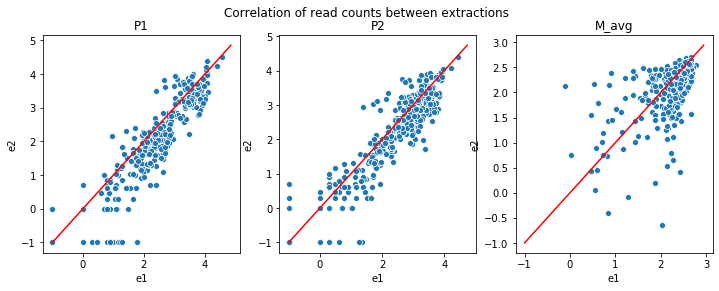

In [16]:
reads['sample_no_extraction'] = reads.panel + '_' + reads.temp + '_' +  reads.feed + '_' + reads.day + '_' + reads.indivudual
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for target, ax in zip(['P1', 'P2', 'M_avg'], axs):
    d = reads[reads.target == target] \
            .pivot(columns='extraction',
                   index='sample_no_extraction',
                   values='log_input')
    sns.scatterplot(data=d,
                x='e1',y='e2',
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_title(target)
fig.suptitle('Correlation of read counts between extractions');


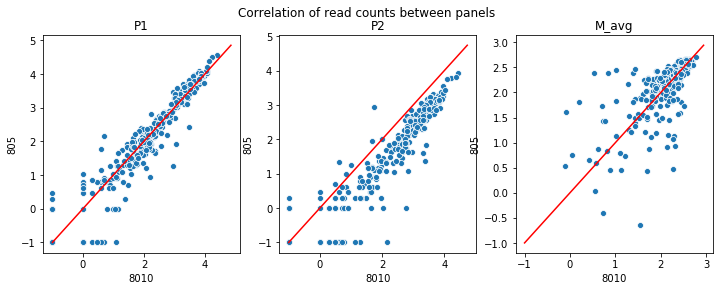

In [17]:
reads['sample_no_panel'] = reads.extraction + '_' + reads.temp + '_' +  reads.feed + '_' + reads.day + '_' + reads.indivudual
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for target, ax in zip(['P1', 'P2', 'M_avg'], axs):
    d = reads[reads.target == target] \
            .pivot(columns='panel',
                   index='sample_no_panel',
                   values='log_input')
    sns.scatterplot(data=d,
                x='8010',y='805',
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_title(target)
fig.suptitle('Correlation of read counts between panels');


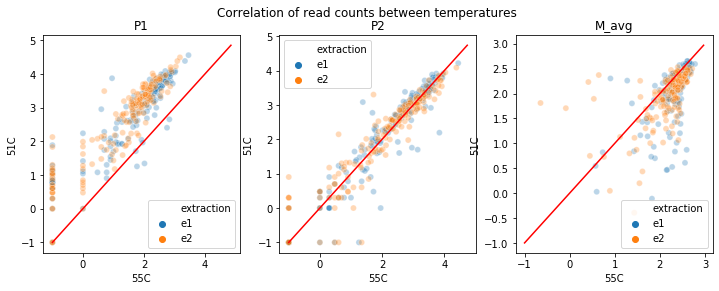

In [18]:
reads['sample_no_temp'] = reads.extraction + '_' + reads.panel + '_' +  reads.feed + '_' + reads.day + '_' + reads.indivudual
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for target, ax in zip(['P1', 'P2', 'M_avg'], axs):
    d = reads[reads.target == target] \
            .pivot(columns='temp',
                   index='sample_no_temp',
                   values='log_input')
    d['extraction'] = d.index.str.slice(0,2)
    sns.scatterplot(data=d,
                x='55C', y='51C', hue='extraction', alpha=.3,
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_title(target)
fig.suptitle('Correlation of read counts between temperatures');
# also checking that extractions behave similarly

## Primer balance

In [19]:
# per-sample read counts 
pr = reads.pivot('s_Sample','target', 'input').reset_index()
pr = parse_sequence_names(pr)
pr['panel_name'] = 'P' + pr.panel
pr['log_P1'] = np.log10(pr['P1'].replace(0,0.1))
pr['log_P2'] = np.log10(pr['P2'].replace(0,0.1))
pr['P1/P2'] = pr.P1 / pr.P2
pr.sample()

target,s_Sample,M_avg,M_sum,P1,P2,panel,temp,extraction,feed,day,indivudual,sampling_point,panel_name,log_P1,log_P2,P1/P2
648,805_55_e2_f15_8d1,360.129032,22328.0,0.0,1.0,805,55C,e2,f15,08,1,f15_08,P805,-1.0,0.0,0.0


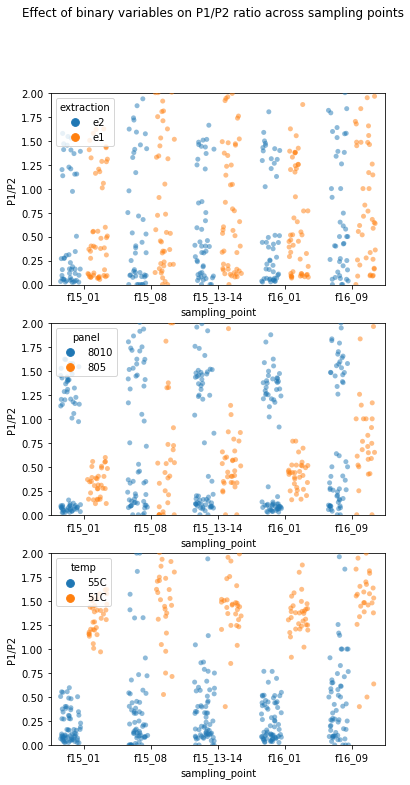

In [20]:
d = pr[pr.day != 'un'].sort_values('sampling_point')
fig, axs = plt.subplots(3,1, figsize=(6, 12))
for ax, col in zip(axs, ['extraction', 'panel', 'temp']):
    sns.stripplot(data = d, dodge=True, 
                x='sampling_point',y='P1/P2',
                hue=col,
                alpha=.5,
                jitter=.3,
                ax=ax)
    ax.set_ylim(0, 2);
fig.suptitle('Effect of binary variables on P1/P2 ratio across sampling points');

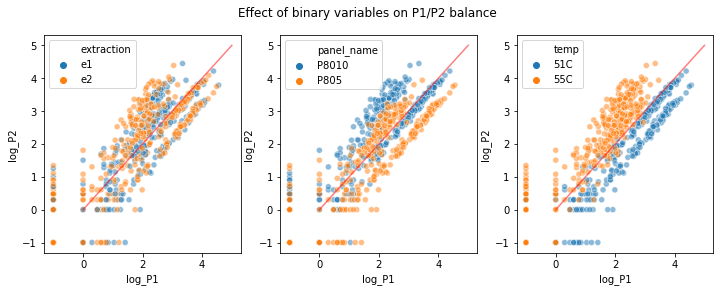

In [21]:
fig, axs = plt.subplots(1,3, figsize=(12, 4))
for ax, col in zip(axs.flatten(), ['extraction', 'panel_name', 'temp']):
    sns.scatterplot(data=pr,
                x='log_P1',y='log_P2',
                hue=col,
                ax=ax,
                alpha=.5);
    ax.plot((0, 5),(0, 5), c='r', alpha=0.5)
fig.suptitle('Effect of binary variables on P1/P2 balance');

P2/P1 regression for e1, 55C
8010 
 LinregressResult(slope=10.89088078521053, intercept=-325.07236180569225, rvalue=0.9489861054627184, pvalue=7.047026687971902e-45, stderr=0.39021372093647283) 

805 
 LinregressResult(slope=2.5052923413124257, intercept=-126.39541395358947, rvalue=0.9481282935437387, pvalue=1.4176729602363505e-44, stderr=0.09057662265828456) 



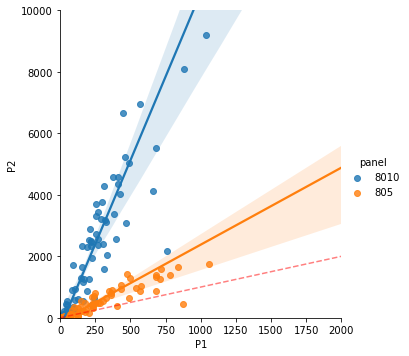

In [22]:
# regression for optimal extraction & temperature
extr = 'e1'
temp = '55C'
reg_d = pr[(pr.extraction == extr) & (pr.temp == temp)]
print('P2/P1 regression for e1, 55C') 
for panel in reg_d.panel.unique():
    x = reg_d.loc[reg_d.panel==panel, 'P1']
    y = reg_d.loc[reg_d.panel==panel, 'P2']
    print(panel,'\n',linregress(x,y),'\n')
g = sns.lmplot(data=reg_d,
           x='P1',
           y='P2',
           hue='panel')
g.axes[0,0].plot((0, 2000),(0, 2000), c='r', alpha=.5, ls='--')
g.axes[0,0].set_xlim(0, 2000)
g.axes[0,0].set_ylim(0, 10000);

P2/P1 regression for e1, 51C
8010 
 LinregressResult(slope=0.7125708790593333, intercept=9.419851660248241, rvalue=0.9872837872811334, pvalue=1.7840971054341307e-70, stderr=0.012372164217828552) 

805 
 LinregressResult(slope=0.170932942311874, intercept=-10.090999500351586, rvalue=0.9929177504925135, pvalue=2.3542371215090012e-81, stderr=0.0022054314686884516) 



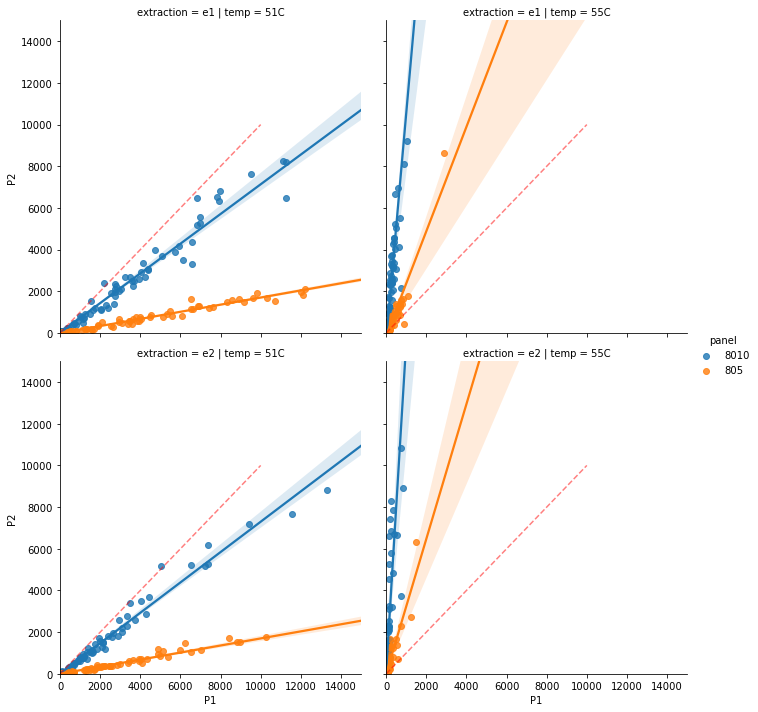

In [23]:
# regression for all conditions

# fig, axs = plt.subplots(2,2, figsize = (12,12))
# conds = itertools.product(('e1','e2')('55C','51C')) 

# for ax, (extr, temp) in zip(axs, conds):

reg_d = pr[(pr.extraction == 'e1') & (pr.temp == '51C')]

print('P2/P1 regression for e1, 51C')
for panel in reg_d.panel.unique():
    x = reg_d.loc[reg_d.panel==panel, 'P1']
    y = reg_d.loc[reg_d.panel==panel, 'P2']
    print(panel,'\n',linregress(x,y),'\n')
g = sns.lmplot(data=pr,
           x='P1',
           y='P2',
           row="extraction", 
           col="temp",
           hue='panel')
for ax in g.axes.flatten():
    ax.plot((0, 10000),(0, 10000), c='r', alpha=.5, ls='--')
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000);

## All replicates together (plus some plots revisited)

In [24]:
READS_V1 = '../../../data/phylo_ampl_dada2/run10_11/dada2/output/stats.tsv'
READS_V2 = '../../../data/phylo_ampl_dada2/run10_11_v2/dada2/output/stats.tsv'

In [25]:
reads_old = pd.read_csv(READS_V1, sep='\t')
# mean read counts across mosquito targets
mean_mosq_old = reads_old[~reads_old.target.str.startswith('P')].groupby('s_Sample').mean().reset_index()
mean_mosq_old['target'] = 'M_avg'
reads_old = pd.concat([reads_old, mean_mosq_old], sort=True)
# remove blanks
reads_old = reads_old[~reads_old.s_Sample.str.contains('blank')]
reads_old.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target
9122,302.0,302.0,302.0,302.0,316.0,302.0,302.0,e1_f15_8d12_55c,4


In [26]:
# parse v1 read names
p = reads_old.s_Sample.str.split('_', expand=True)
reads_old['extraction'] = p[0]
reads_old['feed'] = p[1]
# parse day and specimen
di = p[2].str.split('d', expand=True)
reads_old['day'] = di[0]
reads_old['individual'] = di[1]
# handle uninfected
u = reads_old['day'].str.startswith('un')
reads_old.loc[u, 'individual'] = reads_old.loc[u, 'day'].str.slice(start=2)
reads_old.loc[u, 'day'] = 'un'
# handle day sorting
sdd = reads_old.day.str.len() == 1
reads_old.loc[sdd, 'day'] = '0' + reads_old.loc[sdd, 'day']
# sampling points - combination of feed and day
reads_old['sampling_point'] = reads_old.feed + '_' + reads_old.day
reads_old['sampling_point'] = reads_old['sampling_point'].replace({'f15_13':'f15_13-14','f15_14':'f15_13-14'})
# parse temp and cycling
reads_old['extension_temp'] = p[3].str.slice(stop=-1) + 'C'
reads_old['cycling'] = p[3].str.get(-1).replace({'s':'sub','c':'std'})
# logscale read counts
reads_old['log_input'] = np.log10(reads_old['input'].replace(0,0.1))
reads_old['log_final'] = np.log10(reads_old['final'].replace(0,0.1))
# set up specimen and replicate
reads_old['specimen'] = reads_old.feed + '_' + reads_old.day + '_' + reads_old.individual
reads_old['replicate'] = 'v1_8020_' + reads_old.cycling + '_' + reads_old.extension_temp + '_' +  reads_old.extraction  + '_' + reads_old.target
reads_old.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,extraction,feed,day,individual,sampling_point,extension_temp,cycling,log_input,log_final,specimen,replicate
21294,89.0,89.0,89.0,89.0,91.0,89.0,89.0,e1_f16_9d4_51c,50,e1,f16,09,4,f16_09,51C,std,1.959041,1.94939,f16_09_4,v1_8020_std_51C_e1_50


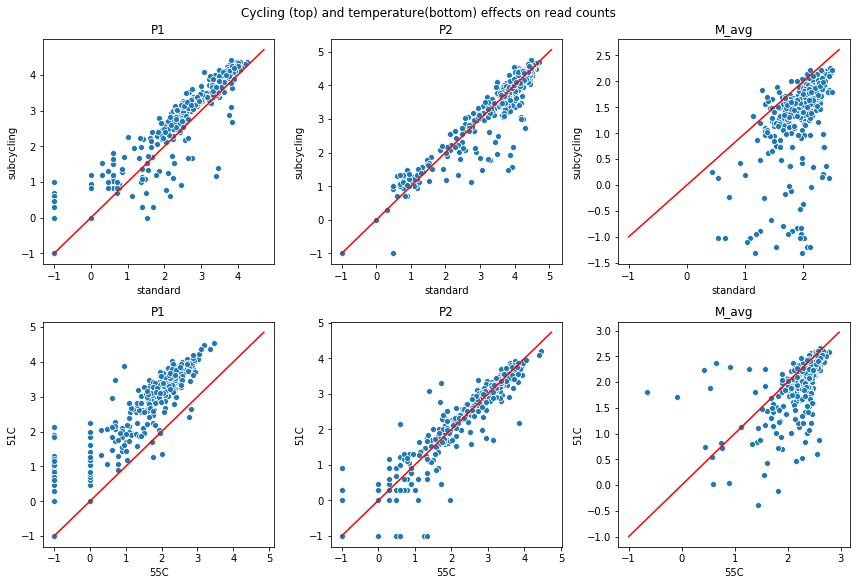

In [27]:
# cycling from v1
reads_old['sample_no_cycling'] = reads_old.s_Sample.str.slice(stop=-1)
fig, axs = plt.subplots(2,3, figsize=(12, 8))
for target, ax in zip(['P1', 'P2', 'M_avg'], axs[0]):
    d = reads_old[reads_old.target == target] \
            .pivot(columns='cycling',
                   index='sample_no_cycling',
                   values='log_input')
    d['extraction'] = d.index.str.slice(0,2)
    sns.scatterplot(data=d,
                x='std',y='sub', #hue='extraction', alpha=.3,
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_xlabel('standard')
    ax.set_ylabel('subcycling')
    ax.set_title(target)
fig.suptitle('Correlation of read counts between cycling conditions');

# temp from v3
reads['sample_no_temp'] = reads.extraction + '_' + reads.panel + '_' +  reads.feed + '_' + reads.day + '_' + reads.indivudual
for target, ax in zip(['P1', 'P2', 'M_avg'], axs[1]):
    d = reads[reads.target == target] \
            .pivot(columns='temp',
                   index='sample_no_temp',
                   values='log_input')
    d['extraction'] = d.index.str.slice(0,2)
    sns.scatterplot(data=d,
                x='55C', y='51C', #hue='extraction', alpha=.3,
                ax=ax)
    plt_max = max(ax.get_xlim()[1], ax.get_ylim()[1])
    ax.plot((-1, plt_max),(-1, plt_max), c='r')
    ax.set_title(target)
fig.suptitle('Cycling (top) and temperature(bottom) effects on read counts', y=1.01);
fig.tight_layout()
# also checking that extractions behave similarly

In [28]:
reads_med = pd.read_csv(READS_V2, sep='\t')
# mean read counts across mosquito targets
mean_mosq_med = reads_med[~reads_med.target.str.startswith('P')].groupby('s_Sample').mean().reset_index()
mean_mosq_med['target'] = 'M_avg'
reads_med = pd.concat([reads_med, mean_mosq_med], sort=True)
# remove blanks
reads_med = reads_med[~reads_med.s_Sample.str.contains('blank')]
reads_med.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target
6659,75.0,75.0,75.0,43.0,75.0,43.0,43.0,8010_e2_f15_14d7,11


In [29]:
# parse v2 sample names
def parse_med_sample_names(reads_med):
    p = reads_med.s_Sample.str.split('_', expand=True)
    reads_med['panel'] = p[0]
    reads_med['extraction'] = p[1]
    reads_med['feed'] = p[2]
    # parse day and indivudual
    di = p[3].str.split('d', expand=True)
    reads_med['day'] = di[0]
    reads_med['indivudual'] = di[1]
    # handle uninfected
    u = reads_med['day'].str.startswith('un')
    reads_med.loc[u, 'indivudual'] = reads_med.loc[u, 'day'].str.slice(start=2)
    reads_med.loc[u, 'day'] = 'un'
    # handle day sorting
    sdd = reads_med.day.str.len() == 1
    reads_med.loc[sdd, 'day'] = '0' + reads_med.loc[sdd, 'day']
    # sampling points - combination of feed and day
    reads_med['sampling_point'] = reads_med.feed + '_' + reads_med.day
    reads_med['sampling_point'] = reads_med['sampling_point'].replace({'f15_13':'f15_13-14','f15_14':'f15_13-14'})
    # remove excessive panels
    reads_med = reads_med[reads_med.panel.isin(['8010','805','plas'])]
    return reads_med
reads_med = parse_med_sample_names(reads_med)
# set up specimen and replicate
reads_med['specimen'] = reads_med.feed + '_' + reads_med.day + '_' + reads_med.indivudual
reads_med['replicate'] = 'v2' + '_' + reads_med.panel + '_' + reads_med.extraction + '_' + reads_med.target 
# logscale read counts
reads_med['log_input'] = np.log10(reads_med['input'].replace(0,0.1))
reads_med['log_final'] = np.log10(reads_med['final'].replace(0,0.1))
reads_med.sample()

,denoisedF,denoisedR,filtered,final,input,merged,nonchim,s_Sample,target,panel,extraction,feed,day,indivudual,sampling_point,specimen,replicate,log_input,log_final
64910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,plas_e2_f15_8d11,21,plas,e2,f15,08,11,f15_08,f15_08_11,v2_plas_e2_21,-1.0,-1.0


In [30]:
# per-sample read counts (except plasmodium speciation panel)
pr_med = reads_med[~reads_med.panel.str.startswith('grc')].pivot('s_Sample','target','input').reset_index()
pr_med = parse_med_sample_names(pr_med)
pr_med['version'] = 'v2'
pr_med.sample()

target,s_Sample,0,1,10,11,12,13,14,15,16,...,M_avg,P1,P2,panel,extraction,feed,day,indivudual,sampling_point,version
478,plas_e2_f15_8d15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,15.0,47.0,plas,e2,f15,08,15,f15_08,v2


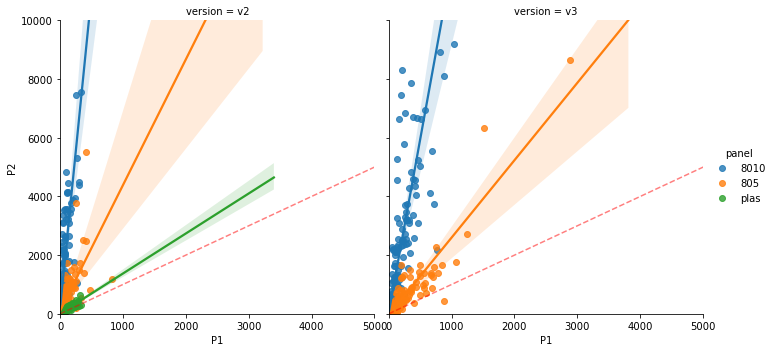

In [31]:
pr['version'] = 'v3'
pr_comb = pd.concat([pr_med, pr[pr.temp=='55C']], sort=False)
g = sns.lmplot(data=pr_comb,
           x='P1',
           y='P2',
#            row="extraction", 
           col="version",
           hue='panel')
for ax in g.axes.flatten():
    ax.plot((0, 10000),(0, 10000), c='r', alpha=.5, ls='--')
    ax.set_xlim(0, 5000)
    ax.set_ylim(0, 10000);

In [32]:
# replicate and specimen for v3
reads['replicate'] = 'v3' + '_' + reads.panel + '_' + reads.temp + '_' + reads.extraction + '_' + reads.target
reads['specimen'] = reads.feed + '_' + reads.day + '_' + reads.indivudual

In [33]:
# combine data
comb_reads = pd.concat([reads_old,
                        reads_med,
                        reads], sort=False)

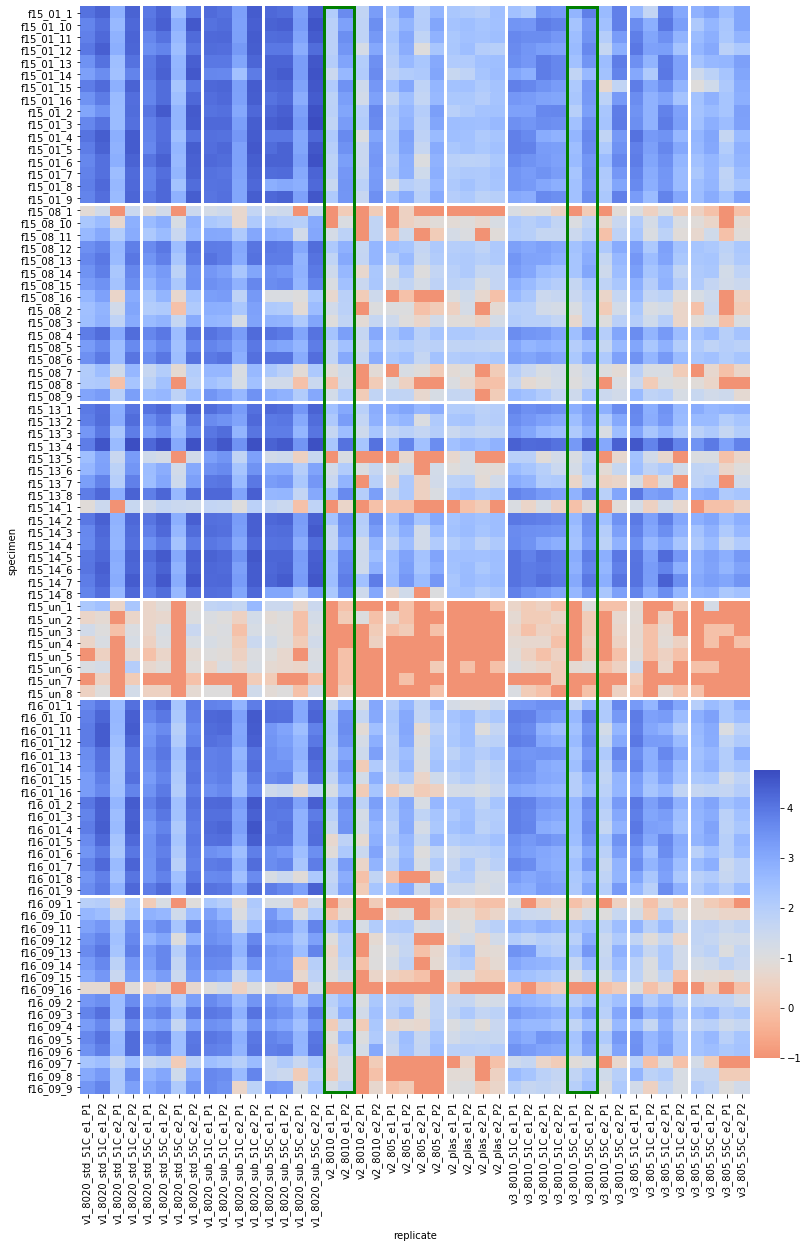

In [36]:
# heatmap for plasmodium read counts across samples and replicates
fig, ax = plt.subplots(1,1,figsize=(12,20))
cbar_ax = fig.add_axes([.905, .15, .03, .2])
sns.heatmap(
    comb_reads[comb_reads.target.str.startswith('P')].pivot('specimen','replicate','log_input'),
    cmap='coolwarm_r',
    center=1,
    ax=ax, 
    cbar_ax = cbar_ax
)
# grid
for x in range(10):
    ax.axvline(4 * (x + 1), linewidth=3, c='w')
for x in (2,4,6,7,9):
    ax.axhline(8 * x, linewidth=3, c='w')
# highlight final conditions
ax.axvline(32, linewidth=3, c='g')
ax.axvline(34, linewidth=3, c='g')
ax.hlines([0,88],[32,32],[34,34],linewidth=6, colors='g');
# same for v2
ax.axvline(16, linewidth=3, c='g')
ax.axvline(18, linewidth=3, c='g')
ax.hlines([0,88],[16,16],[18,18],linewidth=6, colors='g');
# fig.suptitle('input read counts across replicates from three runs');

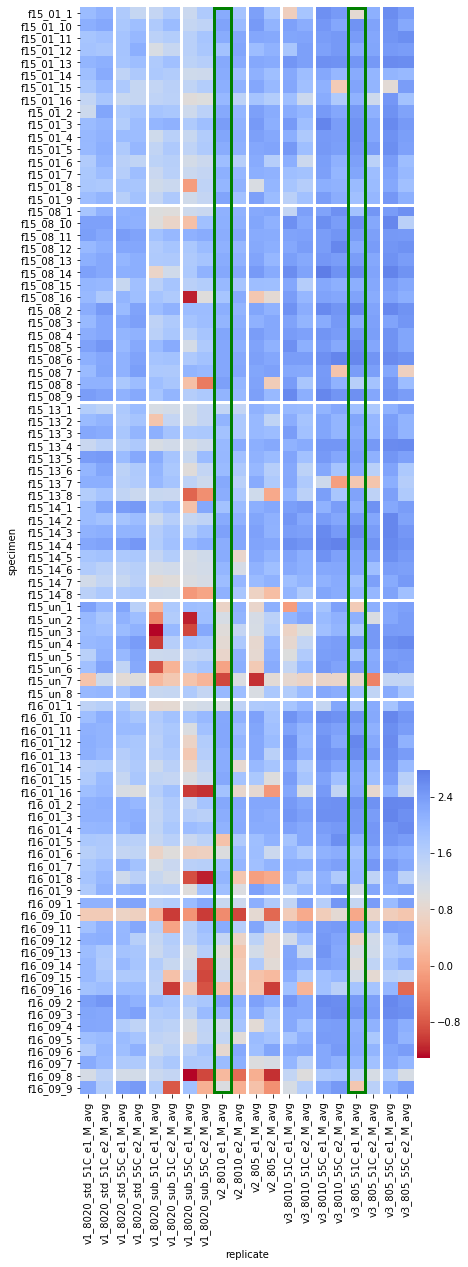

In [38]:
# heatmap for averaged mosquito read counts across samples and replicates
fig, ax = plt.subplots(1,1,figsize=(6,20))
cbar_ax = fig.add_axes([.905, .15, .03, .2])
sns.heatmap(
    comb_reads[(comb_reads.target == 'M_avg') &
               ~comb_reads.replicate.str.contains('plas')] \
        .pivot('specimen','replicate','log_input'),
    cmap='coolwarm_r',
    center=1,
    ax=ax, 
    cbar_ax = cbar_ax
)
# grid
for x in range(10):
    ax.axvline(2 * (x + 1), linewidth=3, c='w')
for x in (2,4,6,7,9):
    ax.axhline(8 * x, linewidth=3, c='w')
# highlight final conditions
ax.axvline(16, linewidth=3, c='g')
ax.axvline(17, linewidth=3, c='g')
ax.hlines([0,88],[16,16],[17,17],linewidth=6, colors='g');
# same for v2
ax.axvline(8, linewidth=3, c='g')
ax.axvline(9, linewidth=3, c='g')
ax.hlines([0,88],[8,8],[9,9],linewidth=6, colors='g');